# Method Stability

In this notebook we evaluate 2 modes of stability of our method.

1. Given that our neural network to find facial landmarks has a mean error of around 4mm, how much impact does this have on the location of Kocher's Point?
2. Given that Kocher's point moves around a bit, based on the landmarks, how much does this affect the location of the Target Point?

In [1]:
from itertools import product
from pathlib import Path
from typing import Any
from random import choice

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import spearmanr

from evdplanner.cli import set_verbosity
from evdplanner.generation import measure_kocher, find_closest_intersection
from evdplanner.geometry import Mesh
from evdplanner.linalg import Vec3
from evdplanner.markups import DisplaySettings, MarkupManager
from evdplanner.rendering import find_target, Ray, IntersectionSort

skin_mesh_file = "mesh_skin.stl"
ventricles_mesh_file = "mesh_ventricles.stl"

manual_landmarks_file = "landmarks_skin.mrk.json"
predicted_landmarks_file = "landmarks_skin_predicted.mrk.json"

evd_file = "EVD.mrk.json"

samples_dir = Path(r"S:\E_ResearchData\evdplanner\Samples")
test_dir = Path(r"S:\E_ResearchData\evdplanner\Test")

scores_file = Path(r"S:\E_ResearchData\evdplanner\MajorityVoting.csv")

set_verbosity(0)


In [2]:
patients = [x.resolve() for x in test_dir.iterdir() if x.is_dir()]
patients += [x.resolve() for x in samples_dir.iterdir() if x.is_dir()]
print(f"Found {len(patients)} patients")

Found 262 patients


In [3]:
records = []

check_radially = True
radius = 1.5
objective_distance_weight = 0.75
thickness_threshold = 10.0
depth_threshold = 80.0

n_tests = 1000
wiggles_per_patient = 10
n_patients = len(patients)
max_error = 10.0

while len(records) < n_tests:
    patient = choice(patients)
    print(f"Processing patient {patient.name} ({len(records) + 1}/{n_tests})...")

    try:
        skin_mesh = Mesh.load(str(patient / skin_mesh_file))
        ventricles_mesh = Mesh.load(str(patient / ventricles_mesh_file))
        gt_landmarks = MarkupManager.load(patient / manual_landmarks_file)
    except:
        print(f"Skin Mesh or landmarks not found for patient {patient.name}.")
        continue
    
    gt_nasion = Vec3(*gt_landmarks.find_fiducial("Nasion").position)
    gt_left_ear = Vec3(*gt_landmarks.find_fiducial("Pre-Auricle Left").position)
    gt_right_ear = Vec3(*gt_landmarks.find_fiducial("Pre-Auricle Right").position)

    print("Measuring GT Kocher's points...")
    gt_left_kp, gt_right_kp = measure_kocher(
        mesh=skin_mesh,
        nasion=gt_nasion,
        left_ear=gt_left_ear,
        right_ear=gt_right_ear,
    )

    print("Finding GT target points...")
    gt_left_tp, _ = find_target(
            ventricles_mesh,
            gt_left_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )
    gt_right_tp, _ = find_target(
        ventricles_mesh,
        gt_right_kp,
        check_radially=check_radially,
        radius=radius,
        objective_distance_weight=objective_distance_weight,
        thickness_threshold=thickness_threshold,
        depth_threshold=depth_threshold,
    )

    for wiggle in range(wiggles_per_patient):
        print(f"Wiggling {wiggle + 1}/{wiggles_per_patient}...")

        left_record = {
            "Patient": patient.name,
            "Side": "Left",
        }
        right_record = {
            "Patient": patient.name,
            "Side": "Right",
        }
        
        wiggle_nasion = gt_nasion + Vec3(
            np.random.uniform(-max_error, max_error), 
            np.random.uniform(-max_error, max_error), 
            np.random.uniform(-max_error, max_error)
        )
        wiggle_left_ear = gt_left_ear + Vec3(
            np.random.uniform(-max_error, max_error),
            np.random.uniform(-max_error, max_error),
            np.random.uniform(-max_error, max_error)
        )
        wiggle_right_ear = gt_right_ear + Vec3(
            np.random.uniform(-max_error, max_error),
            np.random.uniform(-max_error, max_error),
            np.random.uniform(-max_error, max_error)
        )

        # Project the wiggled points to the skin mesh
        wiggle_nasion = skin_mesh.intersect(
            ray=Ray(skin_mesh.origin, (wiggle_nasion - skin_mesh.origin).unit_vector),
            sorting=IntersectionSort.Farthest,
        )
        wiggle_left_ear = skin_mesh.intersect(
            ray=Ray(skin_mesh.origin, (wiggle_left_ear - skin_mesh.origin).unit_vector),
            sorting=IntersectionSort.Farthest,
        )
        wiggle_right_ear = skin_mesh.intersect(
            ray=Ray(skin_mesh.origin, (wiggle_right_ear - skin_mesh.origin).unit_vector),
            sorting=IntersectionSort.Farthest,
        )

        if wiggle_nasion is None or wiggle_left_ear is None or wiggle_right_ear is None:
            print(f"Intersection failed for patient {patient.name}.")
            continue
        
        wiggle_nasion = wiggle_nasion.position
        wiggle_left_ear = wiggle_left_ear.position
        wiggle_right_ear = wiggle_right_ear.position

        left_record["N Error"] = (wiggle_nasion - gt_nasion).length
        right_record["N Error"] = (wiggle_nasion - gt_nasion).length
        left_record["LPA Error"] = (wiggle_left_ear - gt_left_ear).length
        right_record["LPA Error"] = (wiggle_left_ear - gt_left_ear).length
        left_record["RPA Error"] = (wiggle_right_ear - gt_right_ear).length
        right_record["RPA Error"] = (wiggle_right_ear - gt_right_ear).length

        for lm in ["N Error", "LPA Error", "RPA Error"]:
            print(f"Left  {lm} = {left_record[lm]} mm")
            print(f"right {lm} = {right_record[lm]} mm")

        print("Measuring predicted Kocher's points...")
        # Measure Kocher's points using the wiggled landmarks
        predicted_left_kp, predicted_right_kp = measure_kocher(
            mesh=skin_mesh,
            nasion=wiggle_nasion,
            left_ear=wiggle_left_ear,
            right_ear=wiggle_right_ear,
        )

        left_record[r"$K$ Difference"] = (predicted_left_kp - gt_left_kp).length
        right_record[r"$K$ Difference"] = (predicted_right_kp - gt_right_kp).length

        print(f"Left  K Difference = {left_record[r'$K$ Difference']} mm")
        print(f"Right K Difference = {right_record[r'$K$ Difference']} mm")

        print("Finding target points...")
        # Find target points using the predicted Kocher's points
        predicted_left_tp, _ = find_target(
            ventricles_mesh,
            predicted_left_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )
        predicted_right_tp, _ = find_target(
            ventricles_mesh,
            predicted_right_kp,
            check_radially=check_radially,
            radius=radius,
            objective_distance_weight=objective_distance_weight,
            thickness_threshold=thickness_threshold,
            depth_threshold=depth_threshold,
        )

        left_record[r"$T$ Difference"] = (predicted_left_tp - gt_left_tp).length
        right_record[r"$T$ Difference"] = (predicted_right_tp - gt_right_tp).length
        left_record["Distance"] = (predicted_left_tp - predicted_left_kp).length
        right_record["Distance"] = (predicted_right_tp - predicted_right_kp).length

        print(f"Left  T Difference = {left_record[r'$T$ Difference']} mm")
        print(f"Right T Difference = {right_record[r'$T$ Difference']} mm")

        records.extend([left_record, right_record])

Processing patient Augmedit SAH_USZ ID 049 (1/1000)...
Measuring GT Kocher's points...
Finding GT target points...
Wiggling 1/10...
Left  N Error = 5.071536100991353 mm
right N Error = 5.071536100991353 mm
Left  LPA Error = 9.765988997839292 mm
right LPA Error = 9.765988997839292 mm
Left  RPA Error = 9.03577847474686 mm
right RPA Error = 9.03577847474686 mm
Measuring predicted Kocher's points...
Left  K Difference = 3.111207042036856 mm
Right K Difference = 4.814568769852011 mm
Finding target points...
Left  T Difference = 0.9222349947599979 mm
Right T Difference = 0.5821669133383746 mm
Wiggling 2/10...
Left  N Error = 5.17524375151528 mm
right N Error = 5.17524375151528 mm
Left  LPA Error = 3.1967382073969492 mm
right LPA Error = 3.1967382073969492 mm
Left  RPA Error = 4.113345762411956 mm
right RPA Error = 4.113345762411956 mm
Measuring predicted Kocher's points...
Left  K Difference = 6.006975361012721 mm
Right K Difference = 5.663827842168228 mm
Finding target points...
Left  T Dif

In [4]:
df = pd.DataFrame.from_records(records)
df.head()

,Patient,Side,N Error,LPA Error,RPA Error,$K$ Difference,$T$ Difference,Distance
0,Augmedit SAH_USZ ID 049,Left,5.071536,9.765989,9.035778,3.111207,0.922235,67.253244
1,Augmedit SAH_USZ ID 049,Right,5.071536,9.765989,9.035778,4.814569,0.582167,67.801602
2,Augmedit SAH_USZ ID 049,Left,5.175244,3.196738,4.113346,6.006975,1.560025,67.927451
3,Augmedit SAH_USZ ID 049,Right,5.175244,3.196738,4.113346,5.663828,0.879356,67.281880
4,Augmedit SAH_USZ ID 049,Left,4.661469,9.161130,11.517998,7.752981,19.142952,80.618047


In [5]:
scores = pd.read_csv(scores_file)
scores = scores.rename(columns={"PatientID": "Patient", "Score": "Kakarla"})
df = df.merge(scores, on=["Patient", "Side"], how="left")
df.head()

,Patient,Side,N Error,LPA Error,RPA Error,$K$ Difference,$T$ Difference,Distance,Modality,Kakarla
0,Augmedit SAH_USZ ID 049,Left,5.071536,9.765989,9.035778,3.111207,0.922235,67.253244,NaN,NaN
1,Augmedit SAH_USZ ID 049,Right,5.071536,9.765989,9.035778,4.814569,0.582167,67.801602,NaN,NaN
2,Augmedit SAH_USZ ID 049,Left,5.175244,3.196738,4.113346,6.006975,1.560025,67.927451,NaN,NaN
3,Augmedit SAH_USZ ID 049,Right,5.175244,3.196738,4.113346,5.663828,0.879356,67.281880,NaN,NaN
4,Augmedit SAH_USZ ID 049,Left,4.661469,9.161130,11.517998,7.752981,19.142952,80.618047,NaN,NaN


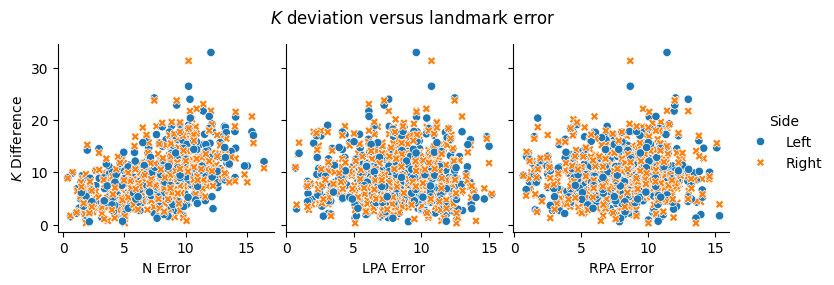

In [6]:
p = sns.pairplot(
    data=df,
    hue="Side",
    markers=["o", "X"],
    diag_kind=None,
    x_vars=[
        "N Error",
        "LPA Error",
        "RPA Error",
    ],
    y_vars=[
        r"$K$ Difference",
    ],
)

p.figure.suptitle(r"$K$ deviation versus landmark error", y=1.1)

plt.show()

Spearman correlation between N Error and $K$ Difference: 0.56 (p-value: 6.72e-85)
Spearman correlation between LPA Error and $K$ Difference: -0.00 (p-value: 9.57e-01)
Spearman correlation between RPA Error and $K$ Difference: 0.04 (p-value: 2.31e-01)
Spearman correlation between $K$ Difference and $T$ Difference: 0.46 (p-value: 8.63e-53)


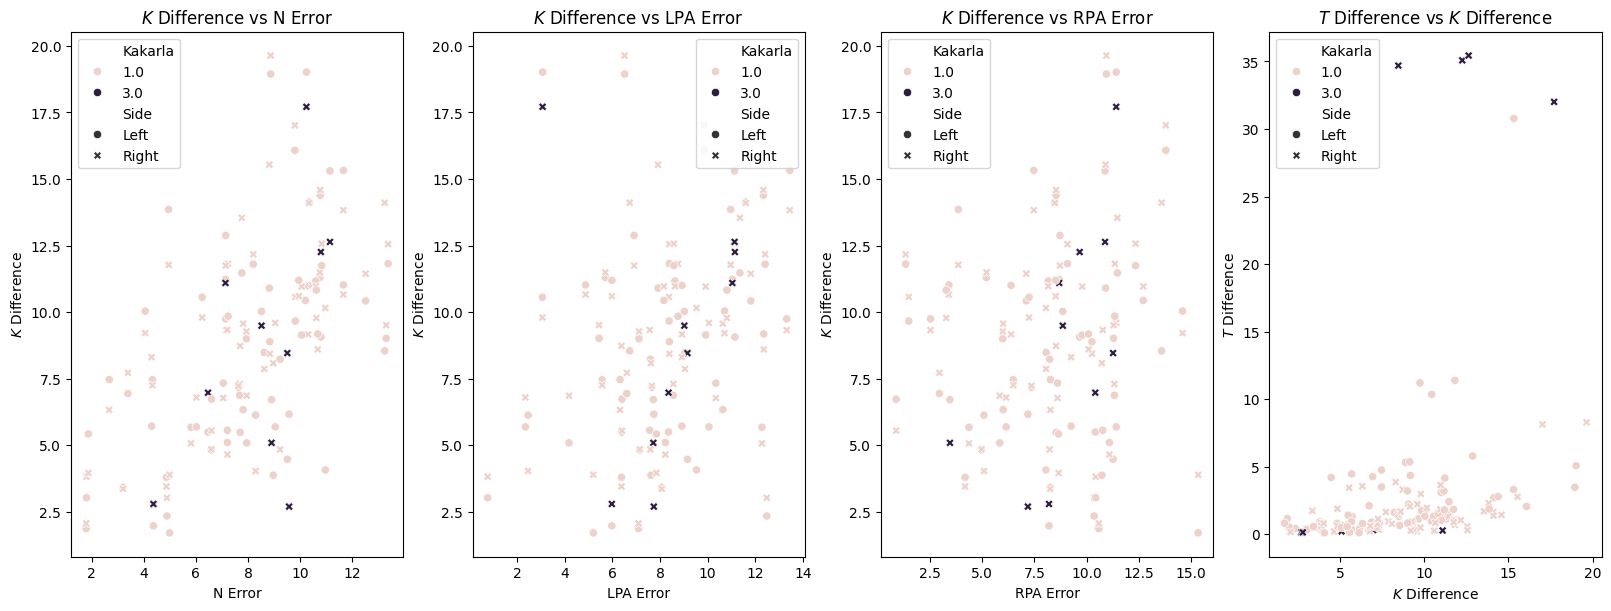

In [7]:
pairs = [
    ("N Error", r"$K$ Difference"),
    ("LPA Error", r"$K$ Difference"),
    ("RPA Error", r"$K$ Difference"),
    (r"$K$ Difference", r"$T$ Difference"),
]

fig, axs = plt.subplots(
    nrows=1,
    ncols=len(pairs),
    figsize=(16, 6),
    constrained_layout=True,
)

for ax, (x, y) in zip(axs, pairs):
    # Calculate Spearman correlation coefficient
    res = spearmanr(df[x], df[y])
    corr = res.statistic
    p = res.pvalue
    print(f"Spearman correlation between {x} and {y}: {corr:.2f} (p-value: {p:.2e})")

    p = sns.scatterplot(
        data=df,
        x=x,
        y=y,
        hue="Kakarla",
        style="Side",
        ax=ax,
    )
    p.set_title(f"{y} vs {x}")
    p.set_xlabel(x)
    p.set_ylabel(y)


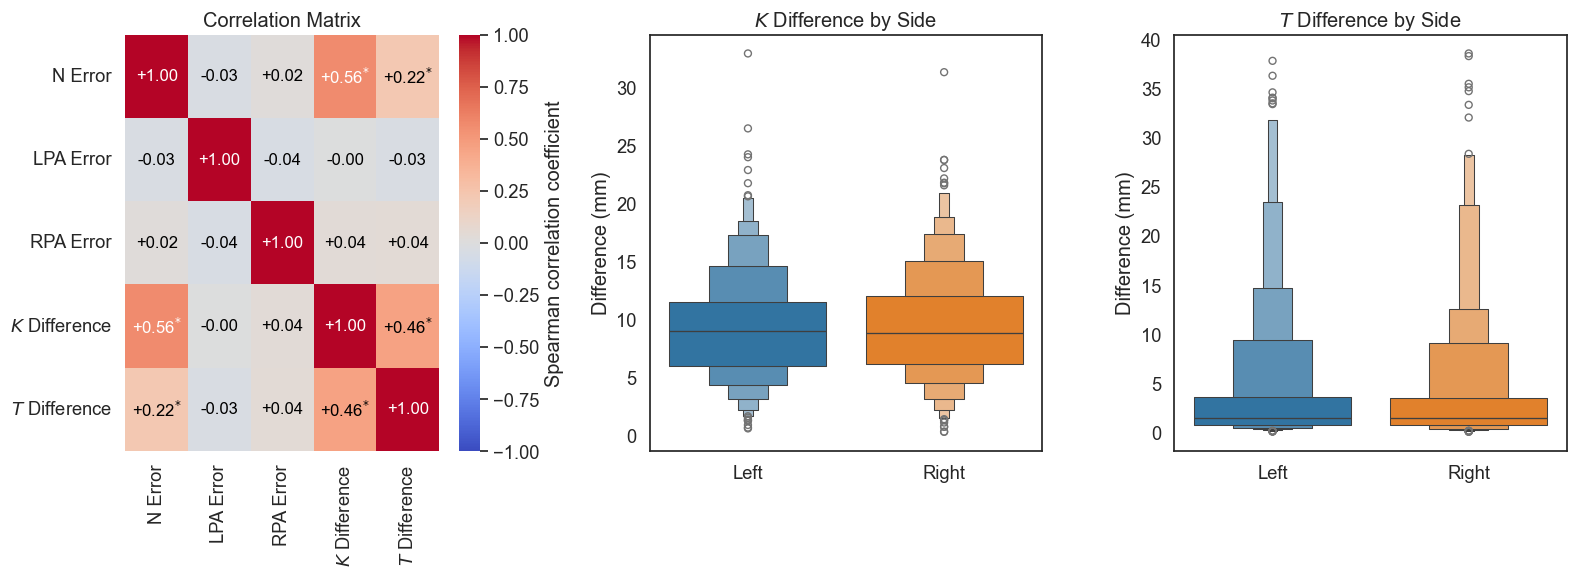

In [27]:
selected_columns = ["N Error", "LPA Error", "RPA Error", r"$K$ Difference", r"$T$ Difference"]

correlations = df[selected_columns].corr(method="spearman")
p_values = df[selected_columns].corr(method=lambda x, y: spearmanr(x, y).pvalue)
mask = np.triu(np.ones_like(correlations, dtype=bool))

sns.set_style("white")
sns.set_context("notebook", font_scale=1.2)

fig, axs = plt.subplots(1, 3, figsize=(16, 6))
sns.heatmap(
    correlations,
    # mask=mask,
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    cbar_kws={"label": "Spearman correlation coefficient"},
    vmin=-1,
    vmax=1,
    center=0,
    ax=axs[0],
)

for i in range(correlations.shape[0]):
    for j in range(correlations.shape[1]):
        # if i >= j:
        #     continue

        corr = f"{correlations.iloc[i, j]:.2f}"
        if correlations.iloc[i, j] > 0:
            corr = f"+{corr}"
        else:
            corr = f"{corr}"
        
        if p_values.iloc[i, j] < 0.001:
            p_val = r"$^{*}$"
        elif p_values.iloc[i, j] < 0.01:
            p_val = r"$^{**}$"
        elif p_values.iloc[i, j] < 0.05:
            p_val = r"$^{***}$"
        else:
            p_val = ""

        color = "black" if abs(correlations.iloc[i, j]) < 0.5 else "white"

        axs[0].text(
            i + 0.5,
            j + 0.5,
            f"{corr}{p_val}",
            ha="center",
            va="center",
            color=color,
            fontsize=12,
        )

axs[0].set_title("Correlation Matrix")

sns.boxenplot(
    data=df,
    x="Side",
    y=r"$K$ Difference",
    hue="Side",
    ax=axs[1],
    order=["Left", "Right"],
)
axs[1].set_title(r"$K$ Difference by Side")
axs[1].set_xlabel("")
axs[1].set_ylabel(r"Difference (mm)")

sns.boxenplot(
    data=df,
    x="Side",
    y=r"$T$ Difference",
    hue="Side",
    ax=axs[2],
    order=["Left", "Right"],
)
axs[2].set_title(r"$T$ Difference by Side")
axs[2].set_xlabel("")
axs[2].set_ylabel(r"Difference (mm)")

plt.tight_layout()
plt.show()

In [9]:
# mean and std of the errors
for col in selected_columns:
    mean = df[col].mean()
    std = df[col].std()
    median = df[col].median()
    low_ci = df[col].quantile(0.025)
    high_ci = df[col].quantile(0.975)
    print(f"{col}: {mean:.2f} ± {std:.2f} (median: {median:.2f}, 95% CI: [{low_ci:.2f}, {high_ci:.2f}])")

N Error: 8.03 ± 3.13 (median: 8.31, 95% CI: [1.79, 13.38])
LPA Error: 8.17 ± 2.92 (median: 8.32, 95% CI: [2.04, 13.32])
RPA Error: 7.88 ± 2.98 (median: 8.14, 95% CI: [1.57, 13.57])
$K$ Difference: 9.38 ± 4.59 (median: 8.91, 95% CI: [1.94, 19.16])
$T$ Difference: 3.91 ± 6.37 (median: 1.46, 95% CI: [0.18, 26.76])
